In [2]:
import numpy as np
import pandas as pd
import igraph as ig
import json
import csv
import matplotlib.pyplot as plt 
import cairocffi
import cairo
import networkx as nx
from scipy.spatial import Delaunay

## Question 6

In [2]:
df = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])
df = df[df['month']==12][['sourceid','dstid','mean_travel_time']]
gd = df.values
graph_dict = {}
for sourceid,dstid,mean_travel_time in gd:
    key = tuple(np.sort([int(sourceid), int(dstid)]))
    if key in graph_dict: graph_dict[key].append(mean_travel_time)
    else: graph_dict[key] = [mean_travel_time]

with open('graph_data.txt','w') as f:
    for loc in graph_dict:
        f.write('{} {} {}\n'.format(loc[0], loc[1], np.mean(graph_dict[loc])))
        
g = ig.Graph.Read(f = 'graph_data.txt', format = 'ncol', directed = False)
gcc = g.components().giant()
print("Number of nodes and edges: ",len(gcc.vs),len(gcc.es))

Number of nodes and edges:  2649 1004955


## Question 7

In [3]:
mst = gcc.spanning_tree(weights = gcc.es["weight"])
visual_style = {}
visual_style["vertex_size"] = 3
ig.plot(mst,**visual_style)

In [4]:
out = ig.plot(mst,**visual_style)
out.save('Q7.png')

In [4]:
location_data = {}
with open('los_angeles_censustracts.json', 'r') as f:
    cur_data = json.loads(f.readline())
    for feature in cur_data['features']:
        coordinates = np.array(feature['geometry']['coordinates'][0][0])
        location_data[feature['properties']['MOVEMENT_ID']] = {'address': feature['properties']['DISPLAY_NAME'],
                                                          'mean_coords': np.mean(coordinates.reshape(-1,2), axis=0)}

In [5]:
mst_edges = mst.es()
print("Coordinates near the two endpoints (the centroid locations) of a few edges:")
for e in mst_edges[:10]:
    x, y = mst.vs(e.tuple[0])[0]['name'], mst.vs(e.tuple[1])[0]['name']
    print(location_data[str(x)]['address'],location_data[str(x)]['mean_coords'], 
          location_data[str(y)]['address'],location_data[str(y)]['mean_coords'])

Coordinates near the two endpoints (the centroid locations) of a few edges:
Census Tract 554001 [-118.133298   33.904119] Census Tract 554002 [-118.141448   33.896526]
Census Tract 461700 [-118.159325   34.153604] Census Tract 460800 [-118.172425   34.180286]
Census Tract 302201 [-118.251349   34.146334] Census Tract 302202 [-118.248811   34.142665]
Census Tract 407101 [-117.967696   34.04101 ] Census Tract 407002 [-117.980572   34.051745]
Census Tract 433401 [-118.043316   34.058606] Census Tract 433402 [-118.038157   34.056957]
Census Tract 543603 [-118.28871    33.803659] Census Tract 294410 [-118.289861   33.797764]
Census Tract 482001 [-118.165951   34.062293] Census Tract 530700 [-118.176633   34.062274]
Census Tract 460800 [-118.172425   34.180286] Census Tract 463800 [-118.167761   34.141469]
Census Tract 269100 [-118.398461   34.057095] Census Tract 217001 [-118.385502   34.04886 ]
Census Tract 011000 [-117.950433   33.881015] Census Tract 001901 [-117.965225   33.868368]


## Question 8

In [7]:
triangles = []
while len(triangles)<1000:
    points = np.random.randint(1,high=len(gcc.vs),size=3)
    try:
        e1, e2, e3 = gcc.get_eid(points[0],points[1]), gcc.get_eid(points[1],points[2]), gcc.get_eid(points[2],points[0])
        weights = [gcc.es['weight'][e1],gcc.es['weight'][e2],gcc.es['weight'][e3]]
        triangles.append(weights)
    except: continue

counter = 0
for i in triangles:
    w1, w2, w3 = i[0], i[1], i[2]
    if w1+w2>w3 and w1+w3>w2 and w3+w2>w1: 
        counter+=1
print(counter/len(triangles))

0.924


## Question 9 and 10

In [6]:
arr = gd
for i in range(0,len(arr)):
    if(arr[i][0]>arr[i][1]):
        t = arr[i][0]
        arr[i][0] = arr[i][1]
        arr[i][1] = t
newdf = pd.DataFrame(arr)
arr1 = newdf.groupby([0,1]).mean().reset_index()
arr1 = arr1.rename(columns={0: "source", 1: "sink", 2: "weight"})

g = nx.from_pandas_edgelist(arr1, 'source','sink', ['weight'])
gcc = g.subgraph(max(nx.connected_components(g), key=len))
mst = nx.minimum_spanning_tree(gcc)
mg = nx.MultiGraph()
mst_cost = 0
for i in mst.edges:
    w = mst.edges[i[0],i[1]]['weight']
    mst_cost += w
    mg.add_edge(i[0],i[1],weight=w)
    mg.add_edge(i[0],i[1],weight=w)


vertices, count = [], 0
for i in mg.nodes:
    vertices.append(i)
    count += 1
    if count>60: 
        break

costs, cur_paths = [], []
for vertex in vertices:
    tour = [u for u,v in nx.eulerian_circuit(mg,source=vertex)]
    cur_path, visited_nodes = [], set()
    for i in tour:
        if i not in visited_nodes: 
            cur_path.append(i) 
            visited_nodes.add(i) 
    cur_path.append(cur_path[0])
    cur_paths.append(cur_path)

    approx_cost = 0
    for i in range(len(cur_path)-1):
        s,t = cur_path[i], cur_path[i+1]
        w = 0
        if mst.has_edge(s,t): 
            w = mst.edges[s,t]['weight']
        else: 
            w = nx.dijkstra_path_length(gcc,s,t)
        approx_cost += w
    costs.append(approx_cost)

min_approx_cost = min(costs)
trajectory = cur_paths[np.argmin(costs)]

In [7]:
print('MST cost:',mst_cost)
print('Approx. cost:',min_approx_cost)
print('Upper bound:',min_approx_cost/mst_cost)

MST cost: 269084.54500000016
Approx. cost: 421489.3149999998
Upper bound: 1.5663824728395292


In [8]:
data = json.load(open('los_angeles_censustracts.json'))
location_data = []
for i in trajectory:
    for j in range(len(data['features'])):
        if data['features'][j]['properties']['MOVEMENT_ID']==str(int(i)):
            cur_loc = data['features'][j]['geometry']['coordinates'][0]
            if len(cur_loc)==1:
                t = np.asarray(cur_loc[0]).mean(axis=0)
                location_data.append(t)
            elif len(cur_loc)==2:
                t = np.asarray(cur_loc[0]+cur_loc[1]).mean(axis=0)
                location_data.append(t)
            elif i==1932.0:
                t = np.asarray(cur_loc[0]+cur_loc[1]+cur_loc[2]+cur_loc[3]+cur_loc[4]+cur_loc[5]).mean(axis=0)
                location_data.append(t)
            else: 
                t = np.asarray(cur_loc).mean(axis=0)
                location_data.append(t)
x,y = [i[0] for i in location_data], [i[1] for i in location_data]

In [9]:
BBox = ((-118.75,   -117.75,      
         33.7, 34.4)) #use these to export map at https://www.openstreetmap.org/

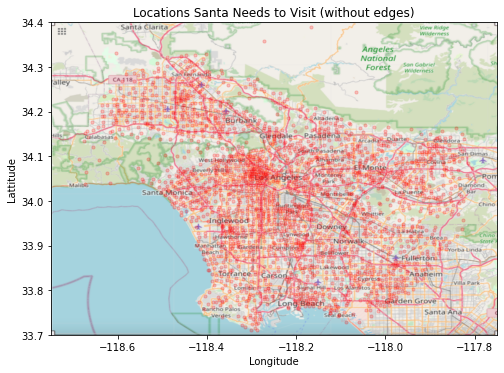

In [10]:
ruh_m = plt.imread('map_LA.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(x, y, zorder=1, alpha= 0.2, c='r', s=10)
ax.set_title('Locations Santa Needs to Visit (without edges)')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('Q10a.png',dpi=300,bbox_inches='tight')
plt.show()

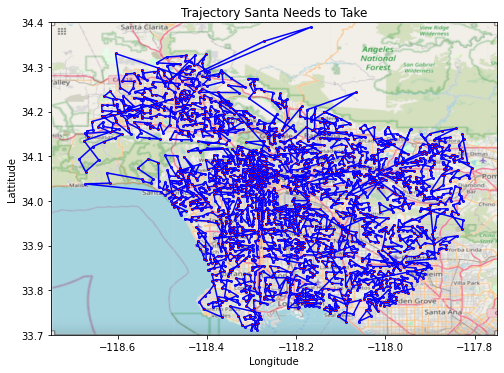

In [11]:
ruh_m = plt.imread('map_LA.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(x,y,color='blue',marker='o',markersize=2,markerfacecolor='red')
ax.set_title('Trajectory Santa Needs to Take')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('Q10b.png',dpi=300,bbox_inches='tight')
plt.show()

In [19]:
for i in range(10):
    print('(',x[i],',',y[i],')')

( -118.12911933333332 , 34.08759475 )
( -118.13138209090911 , 34.09626386363636 )
( -118.13785063157897 , 34.09645121052631 )
( -118.13224544444446 , 34.10349303174603 )
( -118.14492316666666 , 34.098681500000005 )
( -118.15023891071432 , 34.09595766071429 )
( -118.15266638571427 , 34.09029572857144 )
( -118.15075123999998 , 34.083419626666675 )
( -118.15280849999998 , 34.098628 )
( -118.15508200990094 , 34.10732695049504 )


## Question 11

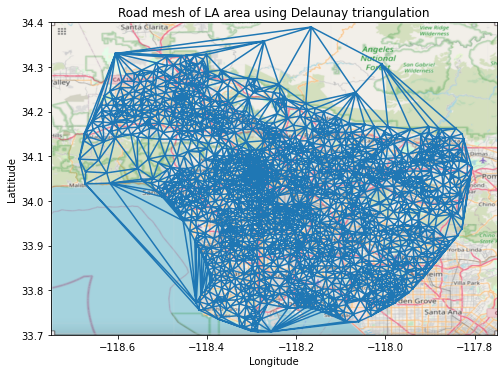

In [3]:
lat_long = {}

with open('los_angeles_censustracts.json', 'r') as f:
    cur_data = json.loads(f.readline())
    features = cur_data['features']
    for feature in features:
        latitude = 0.0
        longitude = 0.0
        if feature['geometry']['type']=='Polygon':
            coordinates = np.array(feature['geometry']['coordinates'][0])
            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        if feature['geometry']['type']=='MultiPolygon':
            coordinates = np.array(feature['geometry']['coordinates'][0][0])
            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        latitude /= len(coordinates)
        longitude /= len(coordinates)
        
        lat_long[feature['properties']['MOVEMENT_ID']] = (feature['properties']['DISPLAY_NAME'], latitude, longitude)

f.close()

lat=[]
lon=[]
for i in range(1,len(lat_long)+1):
    lat.append(lat_long[str(i)][1])
    lon.append(lat_long[str(i)][2])
lat_lon = tuple(zip(lat, lon)) 
delaunay_out = Delaunay(lat_lon)

BBox = ((-118.75,   -117.75,      
         33.7, 34.4))
ruh_m = plt.imread('map_LA.png')

fig, ax = plt.subplots(figsize = (8,7))
plt.triplot(lon, lat, delaunay_out.simplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('Q11a.png',dpi=300,bbox_inches='tight')
plt.show()

In [4]:
g_del=ig.Graph()
g_del.add_vertices(len(delaunay_out.points))
remove_duplicates=set()
for i in range(len(delaunay_out.simplices)):
    a=((delaunay_out.simplices[i][0], delaunay_out.simplices[i][1]))
    b=((delaunay_out.simplices[i][0], delaunay_out.simplices[i][2]))
    c=((delaunay_out.simplices[i][1], delaunay_out.simplices[i][2]))
    list(a).sort()
    list(b).sort()
    list(c).sort()
    if not a in remove_duplicates:
        remove_duplicates.add(a)
        g_del.add_edges([a])
    if not b in remove_duplicates:
        remove_duplicates.add(b)
        g_del.add_edges([b])
    if not c in remove_duplicates:
        remove_duplicates.add(c)
        g_del.add_edges([c])

In [5]:
visual_style = {}
visual_style["vertex_size"] = 3
ig.plot(g_del,**visual_style)

In [7]:
out = ig.plot(g_del,**visual_style)
out.save('Q11b.png')

## Question 13

In [28]:
malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
vcar=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))/1.05
max_car_num=(3600*vcar)/(5.4 + vcar)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i
        
print('Number of edge-disjoint paths: ',g_del.adhesion(long_beach_node,malibu_node)-1)
print('Degree Distribution of nodes (Malibu, Long Beach): ', g_del.degree(malibu_node,mode='out')-1,g_del.degree(long_beach_node,mode='in')-1)

Number of edge-disjoint paths:  6
Degree Distribution of nodes (Malibu, Long Beach):  6 8


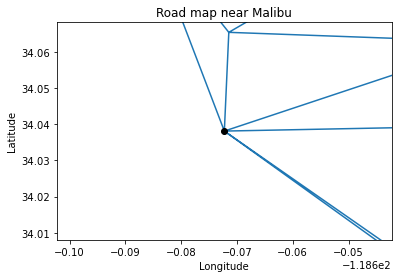

In [23]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[malibu_node][0]-0.03,lat_lon[malibu_node][0]+0.03)
plt.xlim(lat_lon[malibu_node][1]-0.03,lat_lon[malibu_node][1]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(lon[malibu_node], lat[malibu_node],'o',color='black')
plt.savefig('Q13a.png',dpi=300,bbox_inches='tight')
plt.show()

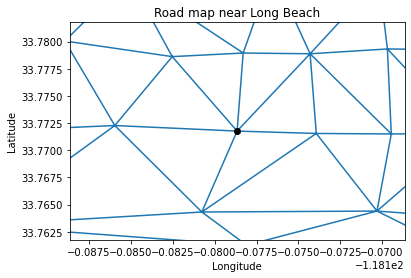

In [37]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[long_beach_node][0]-0.01,lat_lon[long_beach_node][0]+0.01)
plt.xlim(lat_lon[long_beach_node][1]-0.01,lat_lon[long_beach_node][1]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(lon[long_beach_node], lat[long_beach_node],'o',color='black')
plt.savefig('Q13b.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 14

In [23]:
g_del_prune=ig.Graph()
g_del_prune.add_vertices(len(delaunay_out.points))
nodes=g_del_prune.vs()
i=0
for node in nodes:
    node['latitude']=lat[i]
    node['longitude']=lon[i]
    i+=1

threshold=(19.2/69)

duplicate_remove=set()
edge_cut=set()
for i in range(len(delaunay_out.simplices)):
    a=((delaunay_out.simplices[i][0], delaunay_out.simplices[i][1]))
    b=((delaunay_out.simplices[i][0], delaunay_out.simplices[i][2]))
    c=((delaunay_out.simplices[i][1], delaunay_out.simplices[i][2]))
    list(a).sort()
    list(b).sort()
    list(c).sort()
    if not a in duplicate_remove:
        duplicate_remove.add(a)
        a_dist_check=np.sqrt((nodes[a[0]]['latitude']-nodes[a[1]]['latitude'])**2+(nodes[a[0]]['longitude']-nodes[a[1]]['longitude'])**2)
        if a_dist_check<threshold:
            g_del_prune.add_edges([a])
        else:
            edge_cut.add(a)
    if not b in duplicate_remove:
        duplicate_remove.add(b)
        b_dist_check=np.sqrt((nodes[b[0]]['latitude']-nodes[b[1]]['latitude'])**2+(nodes[b[0]]['longitude']-nodes[b[1]]['longitude'])**2)
        if b_dist_check<threshold:
            g_del_prune.add_edges([b])
        else:
            edge_cut.add(b)
    if not c in duplicate_remove:
        duplicate_remove.add(c)
        c_dist_check=np.sqrt((nodes[c[0]]['latitude']-nodes[c[1]]['latitude'])**2+(nodes[c[0]]['longitude']-nodes[c[1]]['longitude'])**2)
        if c_dist_check<threshold:
            g_del_prune.add_edges([c])
        else:
            edge_cut.add(c)
            
edge_cut_list=list(edge_cut)
simplices_list=[]
for simplex in delaunay_out.simplices:
    for edge in edge_cut_list:
        if edge[0] in simplex and edge[1] in simplex:
            simplices_list.append(list(simplex))
        
new_delaunay_out_desimplices = [i for i in delaunay_out.simplices if i not in np.array(simplices_list)]

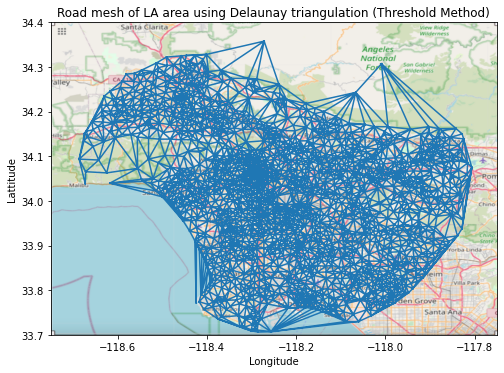

In [24]:
BBox = ((-118.75,   -117.75,      
         33.7, 34.4))
ruh_m = plt.imread('map_LA.png')

fig, ax = plt.subplots(figsize = (8,7))
plt.triplot(lon, lat, new_delaunay_out_desimplices)
ax.set_title('Road mesh of LA area using Delaunay triangulation (Threshold Method)')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('Q14a.png',dpi=300,bbox_inches='tight')
plt.show()

In [25]:
visual_style = {}
visual_style["vertex_size"] = 3
ig.plot(g_del_prune,**visual_style)

In [29]:
out = ig.plot(g_del,**visual_style)
out.save('Q14b.png')

## Question 15

In [26]:
print('Number of edge-disjoint paths: ',g_del_prune.adhesion(long_beach_node,malibu_node)-1)
print('Degree Distribution of nodes (Malibu, Long Beach): ', g_del_prune.degree(malibu_node,mode='out')-1,g_del_prune.degree(long_beach_node,mode='in')-1)

Number of edge-disjoint paths:  3
Degree Distribution of nodes (Malibu, Long Beach):  3 8


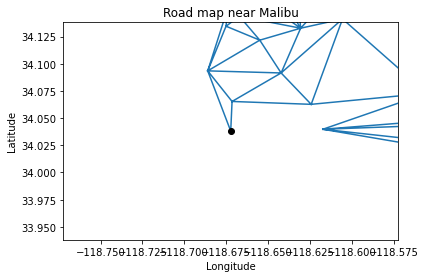

In [32]:
plt.triplot(lon, lat, new_delaunay_out_desimplices)
plt.ylim(lat_lon[malibu_node][0]-0.1,lat_lon[malibu_node][0]+0.1)
plt.xlim(lat_lon[malibu_node][1]-0.1,lat_lon[malibu_node][1]+0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(lon[malibu_node], lat[malibu_node],'o',color='black')
plt.savefig('Q15a.png',dpi=300,bbox_inches='tight')
plt.show()

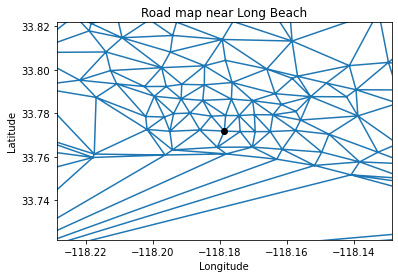

In [33]:
plt.triplot(lon, lat, new_delaunay_out_desimplices)
plt.ylim(lat_lon[long_beach_node][0]-0.05,lat_lon[long_beach_node][0]+0.05)
plt.xlim(lat_lon[long_beach_node][1]-0.05,lat_lon[long_beach_node][1]+0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(lon[long_beach_node], lat[long_beach_node],'o',color='black')
plt.savefig('Q15b.png',dpi=300,bbox_inches='tight')
plt.show()